In [1]:
library(tidyverse)
library(coin)
library(pROC)
library(ggExtra)
library(RColorBrewer)
library(cowplot)
library(grid)
library(gridExtra)
library(SIAMCAT)
library(yaml)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.2.1     v purrr   0.3.2
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   0.8.3     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: survival
Type 'citation("pROC")' for a citation.

Attaching package: 'pROC'

The following objects are masked from 'package:stats':

    cov, smooth, var


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************


Attaching package: 'gridExtra'

The following object is masked from 'package:dplyr':

    combine

Loading required package: mlr
Loading required package: Pa

In [2]:
parameters <- yaml.load_file('parameters.yaml')
tag <- 'species'
log.n0 <- ifelse(tag=='species',
                 as.numeric(parameters$associations$log.n0),
                 as.numeric(parameters$associations$log.n0.func))
mult.corr <- parameters$associations$mult.corr

In [8]:
fn.feat <- paste0('data/species/feat_rel_crc.tsv')
feat.all <- as.matrix(read.table(fn.feat, sep = '\t', header = TRUE, 
                                stringsAsFactors = FALSE, 
                                check.name = FALSE, quote = ''))
meta <- read_tsv('data/meta/meta_crc.tsv')
stopifnot(all(meta$Sample_ID %in% colnames(feat.all)))
studies <- meta %>% pull(Study) %>% unique

Parsed with column specification:
cols(
  Sample_ID = col_character(),
  External_ID = col_character(),
  Age = col_double(),
  Gender = col_character(),
  BMI = col_double(),
  Country = col_character(),
  AJCC_stage = col_character(),
  TNM_stage = col_character(),
  Localization = col_character(),
  Study = col_character(),
  Sampling_rel_to_colonoscopy = col_character(),
  FOBT = col_character(),
  Group = col_character(),
  Diabetes = col_double(),
  Vegetarian = col_double(),
  Smoking = col_double(),
  Library_Size = col_double()
)


In [5]:
head(meta)

Sample_ID,External_ID,Age,Gender,BMI,Country,AJCC_stage,TNM_stage,Localization,Study,Sampling_rel_to_colonoscopy,FOBT,Group,Diabetes,Vegetarian,Smoking,Library_Size
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
CCIS00146684ST-4-0,FR-726,72,F,25,FRA,NA,NA,NA,FR-CRC,BEFORE,Negative,CTR,NA,NA,NA,35443944
CCIS00281083ST-3-0,FR-060,53,M,32,FRA,NA,NA,NA,FR-CRC,BEFORE,Negative,CTR,NA,NA,NA,19307896
CCIS02124300ST-4-0,FR-568,35,M,23,FRA,NA,NA,NA,FR-CRC,BEFORE,Negative,CTR,NA,NA,NA,42141246
CCIS02379307ST-4-0,FR-828,67,M,28,FRA,I,T1N0M0,RC,FR-CRC,BEFORE,Positive,CRC,NA,NA,NA,4829533
CCIS02856720ST-4-0,FR-027,74,M,27,FRA,NA,NA,NA,FR-CRC,BEFORE,Positive,CTR,NA,NA,NA,34294675
CCIS03473770ST-4-0,FR-192,29,M,24,FRA,NA,NA,NA,FR-CRC,BEFORE,Negative,CTR,NA,NA,NA,20262319


In [6]:
head(feat.all)

,CCIS00146684ST-4-0,CCIS00281083ST-3-0,CCIS02124300ST-4-0,CCIS02379307ST-4-0,CCIS02856720ST-4-0,CCIS03473770ST-4-0,CCIS03857607ST-4-0,CCIS05314658ST-4-0,CCIS06260551ST-3-0,CCIS07277498ST-4-0,...,SAMEA3136766,SAMEA3136767,SAMEA3136768,SAMEA3136769,SAMEA3178936,SAMEA3178937,SAMEA3178938,SAMEA3178939,SAMEA3178940,SAMEA3178943
Streptococcus anginosus [ref_mOTU_v2_0004],0.0000000000,0,6.560173e-05,0.0000000000,4.704111e-05,0.0002311604,0.000000e+00,9.863878e-05,0.0006362942,0.000000e+00,...,0.0000000000,5.925926e-05,0.0002255639,2.043597e-04,0.000000000,0,7.119972e-05,8.754268e-05,0.0001053741,0.000000000
Enterobacteriaceae sp. [ref_mOTU_v2_0036],0.0001266357,0,1.640043e-04,0.0020781380,3.175275e-02,0.0052396363,9.356725e-05,3.846913e-03,0.0215067447,0.000000e+00,...,0.2100243798,1.707852e-01,0.7743609023,1.754768e-01,0.000452284,0,5.695977e-04,2.626280e-04,0.0038988409,0.001612133
Citrobacter sp. [ref_mOTU_v2_0076],0.0000000000,0,0.000000e+00,0.0000000000,0.000000e+00,0.0000000000,0.000000e+00,0.000000e+00,0.0030542123,0.000000e+00,...,0.0000000000,0.000000e+00,0.0000000000,6.811989e-05,0.000000000,0,0.000000e+00,0.000000e+00,0.0000000000,0.000000000
Klebsiella michiganensis/oxytoca [ref_mOTU_v2_0079],0.0000000000,0,0.000000e+00,0.0000000000,0.000000e+00,0.0000000000,0.000000e+00,0.000000e+00,0.0000000000,0.000000e+00,...,0.0005019360,0.000000e+00,0.1137593985,0.000000e+00,0.000000000,0,0.000000e+00,8.754268e-05,0.0000000000,0.000000000
Enterococcus faecalis [ref_mOTU_v2_0116],0.0000000000,0,1.968052e-04,0.0004156276,0.000000e+00,0.0025427647,0.000000e+00,0.000000e+00,0.0001272588,9.766579e-05,...,0.0001434103,0.000000e+00,0.0055639098,0.000000e+00,0.000000000,0,0.000000e+00,0.000000e+00,0.0002107482,0.000000000
Lactobacillus salivarius [ref_mOTU_v2_0125],0.0000000000,0,0.000000e+00,0.0000000000,0.000000e+00,0.0000000000,0.000000e+00,0.000000e+00,0.0001272588,0.000000e+00,...,0.0000000000,1.185185e-04,0.0004511278,6.811989e-05,0.000000000,0,1.423994e-04,0.000000e+00,0.0000000000,0.000000000


In [9]:
# Block for colonoscopy and study as well
meta <- meta %>%
    filter(!is.na(Sampling_rel_to_colonoscopy)) %>%
    mutate(block=ifelse(Study!='CN-CRC', Study, 
                        paste0(Study, '_', Sampling_rel_to_colonoscopy)))
feat.all <- feat.all[, meta$Sample_ID]

In [10]:
head(meta)

Sample_ID,External_ID,Age,Gender,BMI,Country,AJCC_stage,TNM_stage,Localization,Study,Sampling_rel_to_colonoscopy,FOBT,Group,Diabetes,Vegetarian,Smoking,Library_Size,block
<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CCIS00146684ST-4-0,FR-726,72,F,25,FRA,NA,NA,NA,FR-CRC,BEFORE,Negative,CTR,NA,NA,NA,35443944,FR-CRC
CCIS00281083ST-3-0,FR-060,53,M,32,FRA,NA,NA,NA,FR-CRC,BEFORE,Negative,CTR,NA,NA,NA,19307896,FR-CRC
CCIS02124300ST-4-0,FR-568,35,M,23,FRA,NA,NA,NA,FR-CRC,BEFORE,Negative,CTR,NA,NA,NA,42141246,FR-CRC
CCIS02379307ST-4-0,FR-828,67,M,28,FRA,I,T1N0M0,RC,FR-CRC,BEFORE,Positive,CRC,NA,NA,NA,4829533,FR-CRC
CCIS02856720ST-4-0,FR-027,74,M,27,FRA,NA,NA,NA,FR-CRC,BEFORE,Positive,CTR,NA,NA,NA,34294675,FR-CRC
CCIS03473770ST-4-0,FR-192,29,M,24,FRA,NA,NA,NA,FR-CRC,BEFORE,Negative,CTR,NA,NA,NA,20262319,FR-CRC


# Statistical Analysis 
### Methods 
- The significance of differential abundance was tested on a per species basis using [a blocked Wilcoxon test](https://www.tandfonline.com/doi/abs/10.1198/000313006X118430)
- To adjust for multiple hypothesis testing, P values were adjusted using [the FDR method](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1995.tb02031.x)
- A generalization of the (logarithmic) fold change is used to have better resolution for sparse microbiome profiles, where 0 entries can render median-based fold change estimates uniformative for a large portion of species with a prevalence below 0.5. 
- The generalized fold change is calculated as the mean difference in a set of predefined quantiles of logarithmic CTR and CRC distributions. Quantiles are used ranging from 0.1 to 0.9 in increments of 0.1

In [11]:
p.val <- matrix(NA, nrow = nrow(feat.all), ncol = length(studies)+1, 
               dimnames = list(row.names(feat.all), c(studies, 'all')))
fc <- p.val
aucs.mat <- p.val 
aucs.all <- vector('list', nrow(feat.all))

In [14]:
cat("Calculating effect size for every feature... \n")
pb <- txtProgressBar(max = nrow(feat.all), style = 3)

for (f in row.names(feat.all)) {
    for (s in studies) {
        x <- feat.all[f, meta %>% filter(Study==s) %>% 
                        filter(Group=='CRC') %>% pull(Sample_ID)]
        y <- feat.all[f, meta %>% filter(Study==s) %>%
                        filter(Group=='CTR') %>% pull(Sample_ID)]
        # Willcoxon test
        p.val[f, s] <- wilcox.test(x, y, exact=FALSE)$p.value
        
        # AUC 
        aucs.all[[f]][[s]] <- c(roc(controls = y, cases = x, 
                                   direction = '<', ci = TRUE, auc = TRUE)$ci)
        aucs.mat[f, s] <- c(roc(controls = y, cases = x, 
                               direction = '<', ci = TRUE, auc = TRUE)$ci)[2]
        
        # FC 
        q.p <- quantile(log10(x+log.n0), probs = seq(.1, .9, .05))
        q.n <- quantile(log10(y+log.n0), probs = seq(.1, .9, .05))
        fc[f,s] <- sum(q.p - q.n)/length(q.p)
    }
    
    # Calculate effect size for all studies combined 
    # Willcoxon + blocking factor 
    d <- data.frame(y=feat.all[f,], 
                    x=meta$Group, block = meta$block)
    p.val[f, 'all'] <- pvalue(wilcox_test(y ~ x | block, data=d))
    x <- feat.all[f, meta %>% filter(Group=='CRC') %>% pull(Sample_ID)]
    y <- feat.all[f, meta %>% filter(Group=='CTR') %>% pull(Sample_ID)]
    fc[f, 'all'] <- mean(fc[f, studies])
    aucs.mat[f, 'all'] <- c(roc(controls = y, cases = x, 
                                direction = '<', ci = TRUE, auc = TRUE)$ci)[2]
    setTxtProgressBar(pb, (pb$getVal()+1))
}
cat('\n')

Calculating effect size for every feature... 
  |======================================================================| 100%


In [19]:
p.adj <- data.frame(apply(p.val, MARGIN = 2, FUN = p.adjust, method = mult.corr), check.names = FALSE)
write.table(fc, file = paste0('files/species/fc.tsv'), 
            quote = FALSE, sep = '\t')
write.table(p.adj, file = paste0('files/species/p_adj.tsv'),
            quote = FALSE, sep = '\t')
write.table(p.val, file = paste0('files/species/p_val.tsv'),
            quote = FALSE, sep = '\t')
write.table(aucs.mat, file = paste0('files/species/aucs.tsv'),
            quote = FALSE, sep = '\t')
save(aucs.all, file = paste0('files/species/aucs_all.RData'))

In [20]:
p.vals <- read.table(paste0('files/species/p_adj.tsv'),
                     sep = '\t', quote = '',
                     stringsAsFactors = FALSE, check.names = FALSE)

fc.mat <- read.table(paste0('files/species/fc.tsv'),
                     sep = '\t', quote = '',
                     stringsAsFactors = FALSE, check.names = FALSE)

auc.mat <- read.table(paste0('files/species/aucs.tsv'),
                      sep = '\t', quote = '',
                      stringsAsFactors = FALSE, check.names = FALSE)

In [22]:
species.heatmap <- rownames(p.vals)[which(p.vals$all < 
                          parameters$associations$alpha.single.study)]

fc.sign <- sign(fc.mat)
fc.sign[fc.sign == 0] <- 1

p.val.signed <- -log10(p.vals[species.heatmap, "all", drop = FALSE]) * 
  fc.sign[species.heatmap, 'all']
top.markers <- rownames(p.val.signed[is.infinite(p.val.signed$all),,drop=FALSE])
p.val.signed[top.markers, 'all'] <- 100 + auc.mat[top.markers, 'all']

species.heatmap.ordered <- rownames(p.val.signed[order(p.val.signed$all),,
                                                 drop = FALSE])

fc.mat.plot <- fc.mat[species.heatmap.ordered,]
p.vals.plot <- p.vals[species.heatmap.ordered,]

In [24]:
# colorscheme for fc heatmap
mx <- max(abs(range(fc.mat.plot, na.rm = TRUE)))
mx <- ifelse(round(mx, digits = 1) < mx, 
             round(mx, digits = 1) + 0.1,
             round(mx, digits = 1)) 
brs <- seq(-mx, mx, by=0.05)
num.col.steps = length(brs) - 1
n = floor(0.45 * num.col.steps)
col.hm = c(rev(colorRampPalette(brewer.pal(9, 'Blues'))(n)),
           rep('#FFFFFF', num.col.steps-2*n),
           colorRampPalette(brewer.pal(9, 'Reds'))(n))
# color scheme for pval heatmap
alpha.breaks = c(1e-06, 1e-05, 1e-04, 1e-03, 1e-02, 1e-01)
p.vals.bin <- data.frame(apply(p.vals.plot, 2, FUN = .bincode,
                               breaks = c(0, alpha.breaks, 1),
                               include.lowest = TRUE),
                         check.names = FALSE)
p.val.greys <- c(paste0('grey',
                        round(seq(from=10, to=80, 
                                  length.out = length(alpha.breaks)))),
                 'white')
names(p.val.greys) <- as.character(1:7)

In [29]:
plot.single.study.heatmap <- function(x) {
    df.plot <- tibble(species=factor(rownames(p.vals.plot), 
                                    levels = rev(rownames(p.vals.plot))),
                     p.vals = as.factor(p.vals.bin[[x]]),
                     fc = fc.mat.plot[[x]])
    
    g1 <- df.plot %>%
    ggplot(aes(x=species, y=1, fill=fc)) + 
      geom_tile() + theme_minimal() + 
      theme(axis.text = element_blank(),
            axis.ticks = element_blank(),
            axis.title = element_blank(),
            panel.grid = element_blank(),
            panel.background = element_rect(fill = NULL, colour = 'black'),
            plot.margin = unit(c(0,0,0,0), 'cm')) + 
      scale_y_continuous(expand = c(0,0)) + 
      scale_fill_gradientn(colours = col.hm, limits = c(-mx, mx), guide = FALSE)
    
    g2 <- df.plot %>%
        ggplot(aes(x=species, y=1, fill=p.vals)) + 
            geom_tile() + theme_minimal() + 
            theme(axis.text = element_blank(),
                  axis.ticks = element_blank(),
                  axis.title = element_blank(),
                  panel.grid = element_blank(),
                  panel.background = element_rect(fill = NULL, colour = 'black'),
                  plot.margin = unit(c(0,0,0,0), 'cm')) + 
            scale_y_continuous(expand = c(0,0)) +
            scale_fill_manual(values = p.val.greys, na.value = 'white', guide = FALSE)
    
    g.return <- plot_grid(g2, g1, ncol=1, rel_heights = c(0.25, 0.75))
    y.grob <- textGrob(x, gp = gpar(fontsize=8), rot = 90)
    grid.arrange(arrangeGrob(g.return, left = y.grob))
}

png 
  2

Warning message:
"Graphs cannot be vertically aligned unless the axis parameter is set. Placing graphs unaligned."

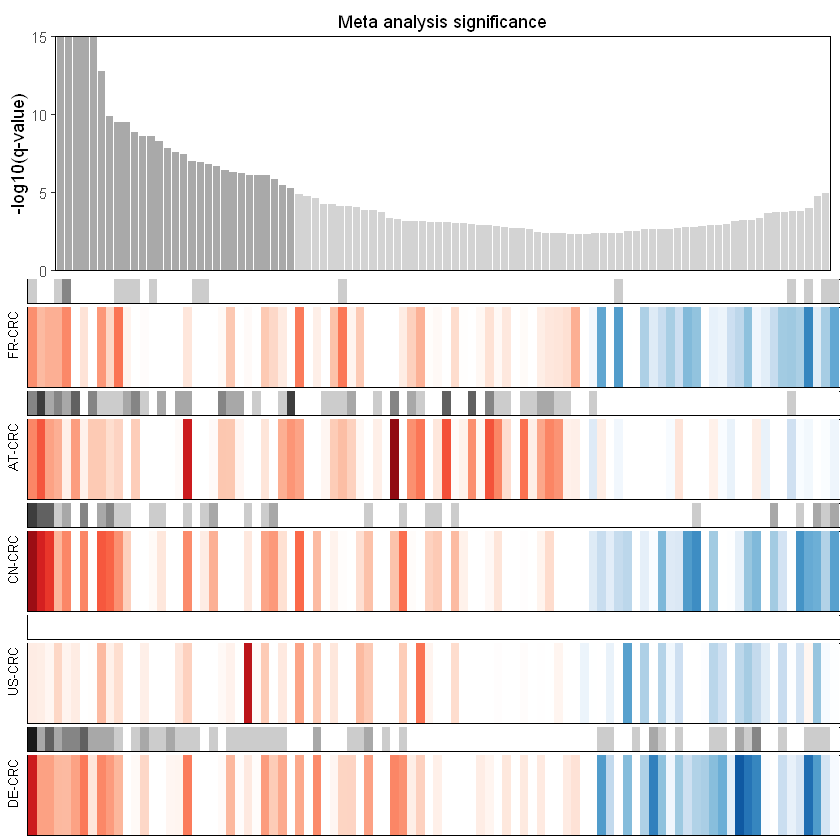

In [31]:
g1 <- tibble(species = factor(rownames(p.vals.plot), 
                              levels = rev(rownames(p.vals.plot))),
             p.vals = -log10(p.vals.plot$all),
             colour = p.vals > 5) %>%
    ggplot(aes(x=species, y=p.vals, fill=colour)) + 
        geom_bar(stat = 'identity') + 
        theme_classic() + 
        xlab("Meta analysis significance") + 
        ylab("-log10(q-value)") + 
        theme(panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              axis.ticks.x = element_blank(),
              axis.text.x = element_blank(),
              panel.background = element_rect(fill = NULL, colour = 'black')) + 
        scale_y_continuous(limits = c(0, 15), expand = c(0,0)) + 
        scale_x_discrete(position = 'top') + 
        scale_fill_manual(values = c('lightgrey', 'darkgrey'), guide=FALSE)

ref.studies <- parameters$ref.studies
pdf("detail_studies.pdf")
g.lst <- lapply(ref.studies, plot.single.study.heatmap)
dev.off()
plot_grid(g1, g.lst[[1]], g.lst[[2]], g.lst[[3]], g.lst[[4]], g.lst[[5]],
          ncol = 1, align = 'v', rel_heights = c(0.3, rep(0.12, 5)))

- The 1st figure is the meta-analysis significance of gut microbial species derived from blocked Wilcoxon tests (n=574 independent observations) is given by the bar height (FDR=0.005). At a meta-analysis FDR of 0.005, 94 microbial species are identified to be differentially abundant in the CRC microbiome out of 849 species consistently detected across studies. A core set of the 29 most significant markers with FDR < 10^-5 
- Underneath, species-level significance, as calculated with a two-sided Wilcoxon test and generalized fold change within individual studies are displayed as heatmap in gray and in color, respectively. 
- Red indicates higher mean abundance in healthy and blue indicates higher mean abundance in CRC patients.

In [33]:
load(paste0('files/species/aucs_all.RData'))
marker.set <- rownames(p.val.signed)[
    abs(p.val.signed$all) > 
        -log10(as.numeric(parameters$associations$alpha.meta))]
p.val.signed.red <- p.val.signed[marker.set, ,drop = FALSE]
marker.set.ordered <- rev(rownames(p.val.signed.red[order(p.val.signed.red$all),,drop = FALSE]))

In [35]:
df.plot <- tibble()
for (i in marker.set.ordered) {
  for (s in ref.studies) {
    temp <- aucs.all[[i]][[s]]
    df.plot <- bind_rows(df.plot, tibble(
      species = i, study = s,
      low = temp[1], auc = temp[2], high = temp[3]
    ))
  }
}

df.plot <- df.plot %>%
    mutate(species = factor(species, levels = marker.set.ordered)) %>%
    mutate(study = factor(study, levels = ref.studies ))

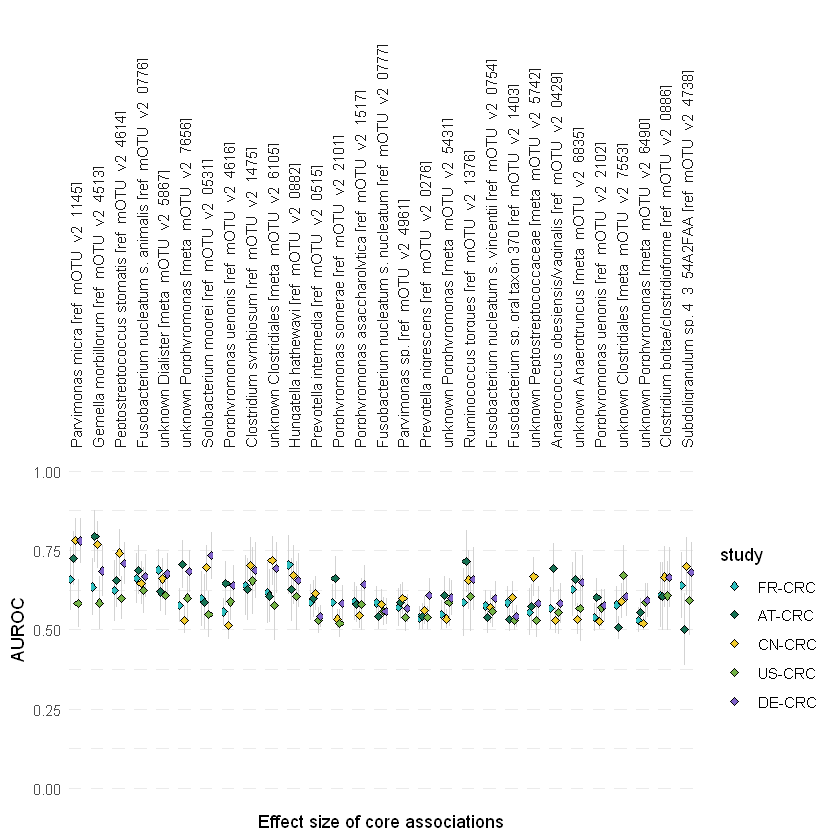

In [39]:
g <- df.plot %>%
  ggplot(aes(x=study, y=auc)) +
    geom_linerange(aes(ymin=low, ymax=high), colour='lightgrey') + 
    geom_point(pch=23, aes(fill=study)) + 
    facet_grid(~species, scales = 'free_x', space = 'free') + 
    theme_minimal() + 
    scale_y_continuous(limits = c(0,1)) +
    theme(panel.grid.major.x = element_blank(),
          axis.ticks.x = element_blank(),
          axis.text.x = element_blank(),
          strip.text = element_text(angle = 90, hjust = 0)) +
    scale_fill_manual(values = unlist(parameters$plotting$study.cols)) +
    ylab('AUROC') + xlab('Effect size of core associations')
g

### The generalized fold change extends the median-based fold change to provide higher resolution in sparse microbiome data 

In [40]:
meta <- read_tsv('data/meta/meta_crc.tsv')
feat <- read.table('data/species/feat_rel_crc.tsv', sep = '\t', quote = '',
                   stringsAsFactors = FALSE, check.names = FALSE)
feat.log <- as.matrix(log10(feat + as.numeric(parameters$associations$log.n0)))

fc.new <- read.table('files/species/fc.tsv', sep = '\t', quote = '',
                     stringsAsFactors = FALSE, check.names = FALSE)
p.adj <- read.table('files/species/p_adj.tsv', sep = '\t', quote = '',
                    stringsAsFactors = FALSE, check.names = FALSE)
auroc <- read.table('files/species/aucs.tsv', sep = '\t', quote = '',
                    stringsAsFactors = FALSE, check.names = FALSE)

Parsed with column specification:
cols(
  Sample_ID = col_character(),
  External_ID = col_character(),
  Age = col_double(),
  Gender = col_character(),
  BMI = col_double(),
  Country = col_character(),
  AJCC_stage = col_character(),
  TNM_stage = col_character(),
  Localization = col_character(),
  Study = col_character(),
  Sampling_rel_to_colonoscopy = col_character(),
  FOBT = col_character(),
  Group = col_character(),
  Diabetes = col_double(),
  Vegetarian = col_double(),
  Smoking = col_double(),
  Library_Size = col_double()
)


In [41]:
# Calculate traditional fold change 
fc.trad <- c()
for (i in rownames(feat.log)) {
    temp.fc <- c()
    for (s in parameters$ref.studies) {
        temp.ctr <- median(feat.log[i, meta %>% 
                                    filter(Group == 'CTR', Study == s) %>%
                                    pull(Sample_ID)])
        temp.crc <- median(feat.log[i, meta %>%
                                    filter(Group == 'CRC', Study == s) %>%
                                    pull(Sample_ID)])
        temp.fc <- c(temp.fc, temp.crc - temp.ctr)
    }
    fc.trad <- c(fc.trad, mean(temp.fc))
}

prev.shift <- c()
for (f in rownames(feat)) {
    prev.crc <- sum(feat[f, meta %>%
                         filter(Group == 'CRC') %>%
                         pull(Sample_ID)] == 0)/
        meta %>% filter(Group == 'CRC') %>% nrow
    prev.ctr <- sum(feat[f, meta %>%
                         filter(Group == 'CTR') %>%
                         pull(Sample_ID)] == 0)/
        meta %>% filter(Group == 'CTR') %>% nrow
    prev.shift <- c(prev.shift, prev.ctr - prev.crc)
}

In [44]:
df.plot <- tibble(species = rownames(p.adj), 
                  old = fc.trad,
                  new = fc.new$all,
                  p.adj = p.adj$all,
                  signif = p.adj < as.numeric(parameters$associations$alpha.meta),
                  AUROC = auroc$all,
                  prev = prev.shift)

In [51]:
g <- df.plot %>%
    filter(!signif) %>%
    ggplot(aes(x=old, y=new)) + 
        geom_point(pch=16, size=2, alpha=0.4, col='darkgrey') + 
        theme_bw() + 
        theme(panel.grid.minor = element_blank()) + 
        xlab('Median fold change (FC)') + 
        ylab('Generalized fold change (gFC)') + 
        geom_point(data = df.plot %>% filter(signif), col='#d9544d', size=2.5)
g.marg <- ggMarginal(g, type = 'histogram')

grob2 <- grobTree(textGrob(paste("Correlation = ", round(cor.test(x=df.plot$old, y=df.plot$AUROC, method = "spearman")$estimate, 3)), 
                                 x = 0.05, y = 0.97, hjust = 0, gp = gpar(col = "red", fontsize = 11, fontface = "bold")))
g2 <- df.plot %>%
  filter(!signif) %>%
  ggplot(aes(x=old, y=AUROC)) + 
    geom_point(pch=16, size=2, alpha=.4, col='darkgrey') + 
    theme_bw() + 
    theme(panel.grid.minor = element_blank()) + 
    xlab('Mean fold change (FC)') +
    ylab('AUROC') + 
    geom_point(data=df.plot %>% filter(signif), col='#d9544d', size=2.5) +
    annotation_custom(grob2) + 
    ylim(0.25, 0.75)
g.marg.2 <- ggMarginal(g2, type = "histogram")

grob3 <- grobTree(textGrob(paste("Correlation = ", round(cor.test(x=df.plot$new, y=df.plot$AUROC, method = "spearman")$estimate, 3)), 
                           x = 0.05, y = 0.97, hjust = 0, gp = gpar(col = "red", fontsize = 11, fontface = "bold")))
g3 <- df.plot %>%
  filter(!signif) %>%
  ggplot(aes(x=new, y=AUROC)) + 
    geom_point(pch=16, size=2, alpha=.4, col='darkgrey') + 
    theme_bw() + 
    theme(panel.grid.minor = element_blank()) + 
    xlab("Generalized fold change (gFC)") + ylab("AUROC") + 
    annotation_custom(grob3) + 
    geom_point(data=df.plot %>% filter(signif), col='#d9544d', size=2.5) + 
    ylim(0.25, 0.75)
g.marg.3 <- ggMarginal(g3, type = "histogram")

grob4 <- grobTree(textGrob(paste("Correlation = ", round(cor.test(x=df.plot$old, y=df.plot$prev, method = "spearman")$estimate, 3)), 
                           x = 0.05, y = 0.97, hjust = 0, gp = gpar(col = "red", fontsize = 11, fontface = "bold")))
g4 <- df.plot %>%
  filter(!signif) %>%
  ggplot(aes(x=old, y=prev)) + 
    geom_point(pch=16, size=2, alpha=.4, col='darkgrey') + 
    theme_bw() + 
    theme(panel.grid.minor = element_blank()) + 
    geom_point(data=df.plot %>% filter(signif), col='#d9544d', size=2.5) +
    annotation_custom(grob4) + 
    xlab('Median fold change (FC)') + ylab('Prevalence shift')
g.marg.4 <- ggExtra::ggMarginal(g4, type = "histogram")

grob5 <- grobTree(textGrob(paste("Correlation = ", round(cor.test(x=df.plot$new, y=df.plot$prev, method = "spearman")$estimate, 3)), 
                           x = 0.05, y = 0.97, hjust = 0, gp = gpar(col = "red", fontsize = 11, fontface = "bold")))
g5 <- df.plot %>%
  filter(!signif) %>%
  ggplot(aes(x=new, y=prev)) + 
  geom_point(pch=16, size=2, alpha=.4, col='darkgrey') + 
  theme_bw() + 
  theme(panel.grid.minor = element_blank()) + 
  geom_point(data=df.plot %>% filter(signif), col='#d9544d', size=2.5) +
  annotation_custom(grob5) + 
  xlab('Generalized fold change (gFC)') + ylab('Prevalence shift')
g.marg.5 <- ggExtra::ggMarginal(g5, type = "histogram")

Warning message in cor.test.default(x = df.plot$old, y = df.plot$AUROC, method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = df.plot$new, y = df.plot$AUROC, method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = df.plot$old, y = df.plot$prev, method = "spearman"):
"Cannot compute exact p-value with ties"Warning message in cor.test.default(x = df.plot$new, y = df.plot$prev, method = "spearman"):
"Cannot compute exact p-value with ties"

In [48]:
df.plot %>% filter(signif)

species,old,new,p.adj,signif,AUROC,prev
<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>
Prevotella nigrescens [ref_mOTU_v2_0276],0.0000000,0.05235075,1.041339e-07,TRUE,0.5600474,0.11935874
Anaerococcus obesiensis/vaginalis [ref_mOTU_v2_0429],0.0000000,0.16723142,5.858106e-07,TRUE,0.5786183,0.15208711
Prevotella intermedia [ref_mOTU_v2_0515],0.0000000,0.12726770,2.451837e-09,TRUE,0.5762263,0.15105868
Solobacterium moorei [ref_mOTU_v2_0531],0.1375083,0.34812485,1.416293e-10,TRUE,0.6398919,0.25874168
Fusobacterium nucleatum s. vincentii [ref_mOTU_v2_0754],0.0000000,0.07408101,2.106989e-07,TRUE,0.5708050,0.14065336
Fusobacterium nucleatum s. animalis [ref_mOTU_v2_0776],0.0000000,0.40633224,0.000000e+00,TRUE,0.6578133,0.29963702
Fusobacterium nucleatum s. nucleatum [ref_mOTU_v2_0777],0.0000000,0.06620940,2.670458e-08,TRUE,0.5669196,0.13339383
Hungatella hathewayi [ref_mOTU_v2_0882],0.6583351,0.43665048,2.442874e-09,TRUE,0.6596831,0.25977011
Clostridium boltae/clostridioforme [ref_mOTU_v2_0886],0.4137338,0.38933567,3.628354e-06,TRUE,0.6365954,0.18723533


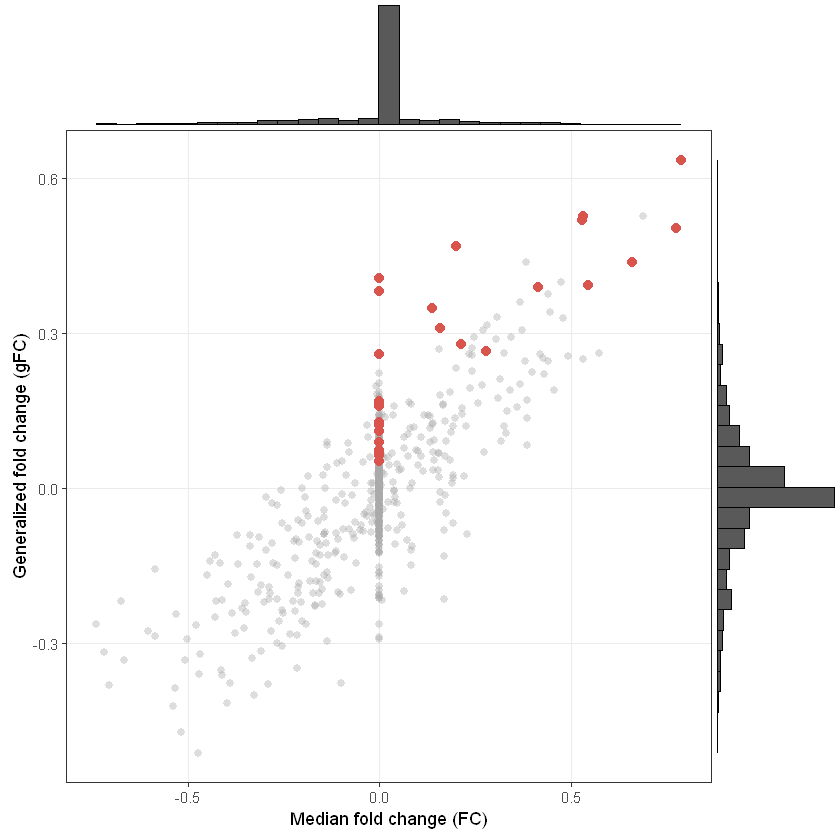

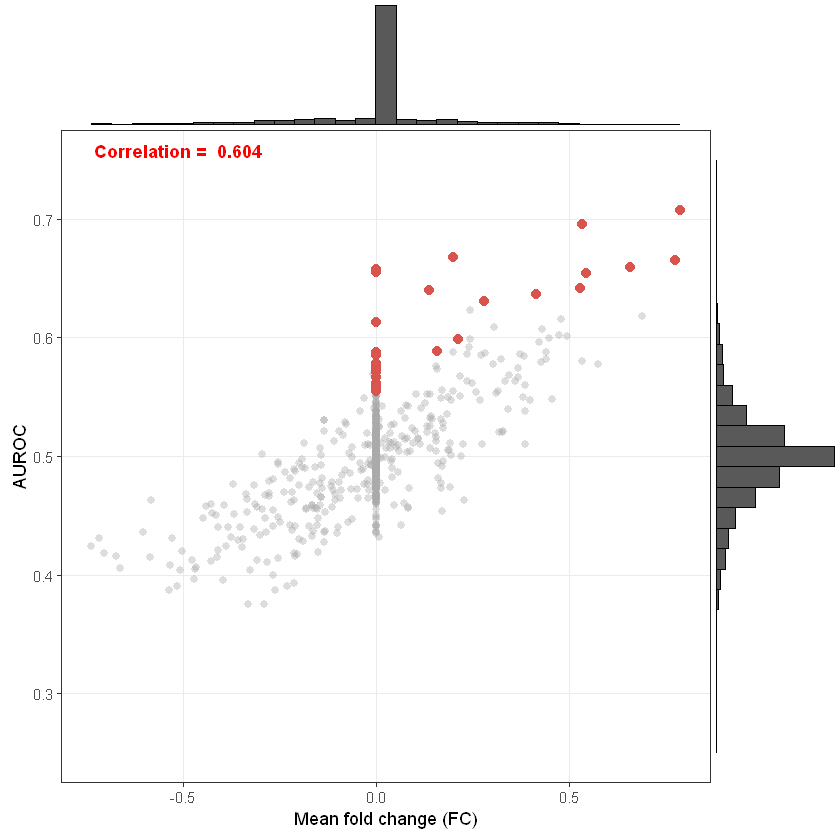

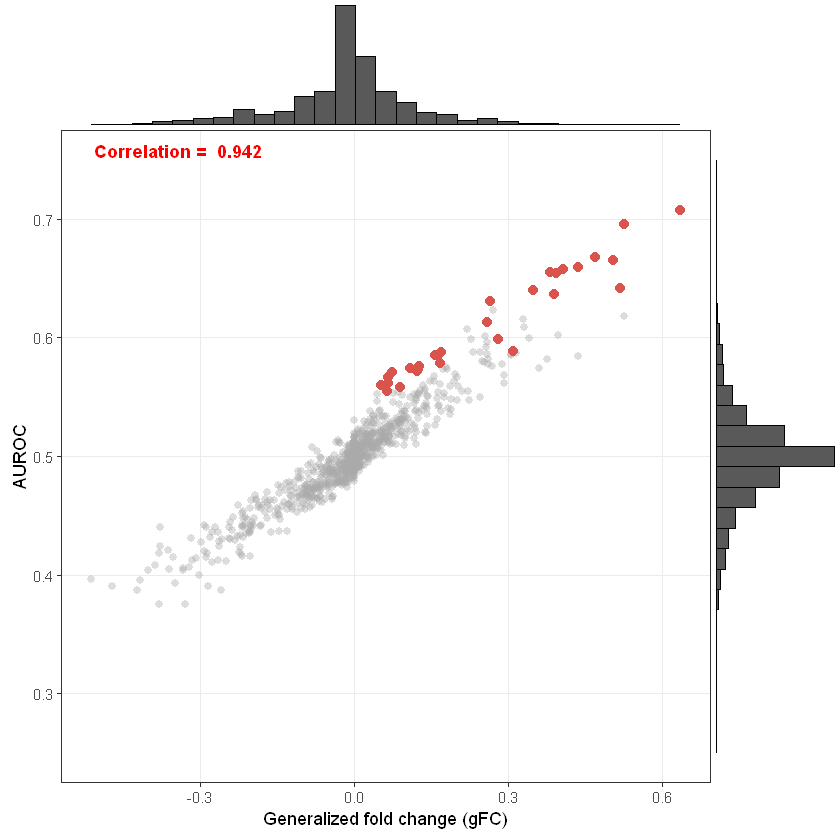

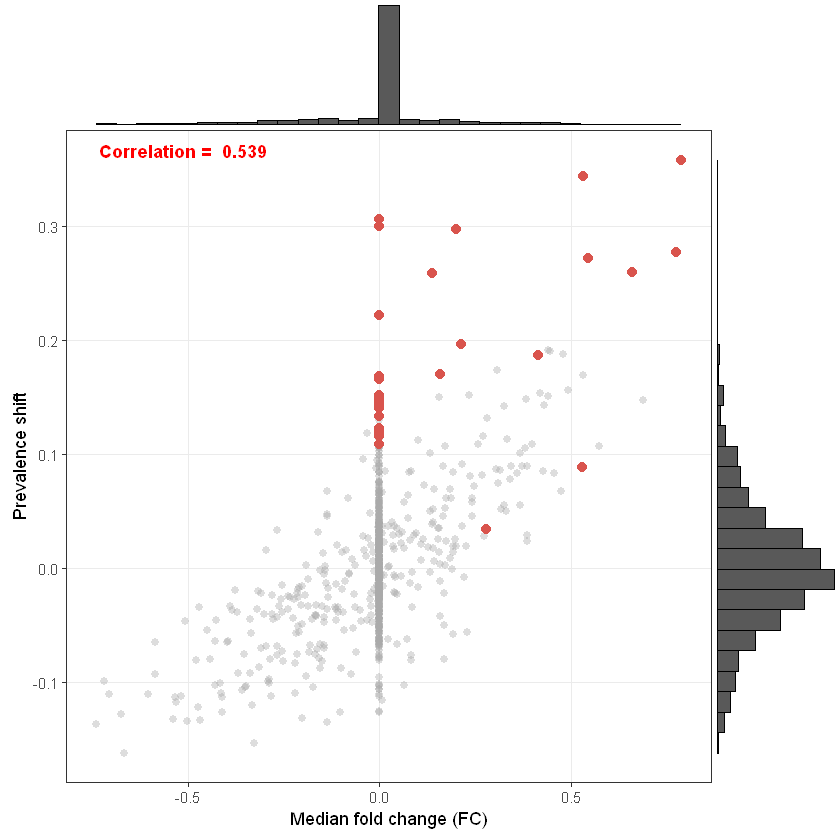

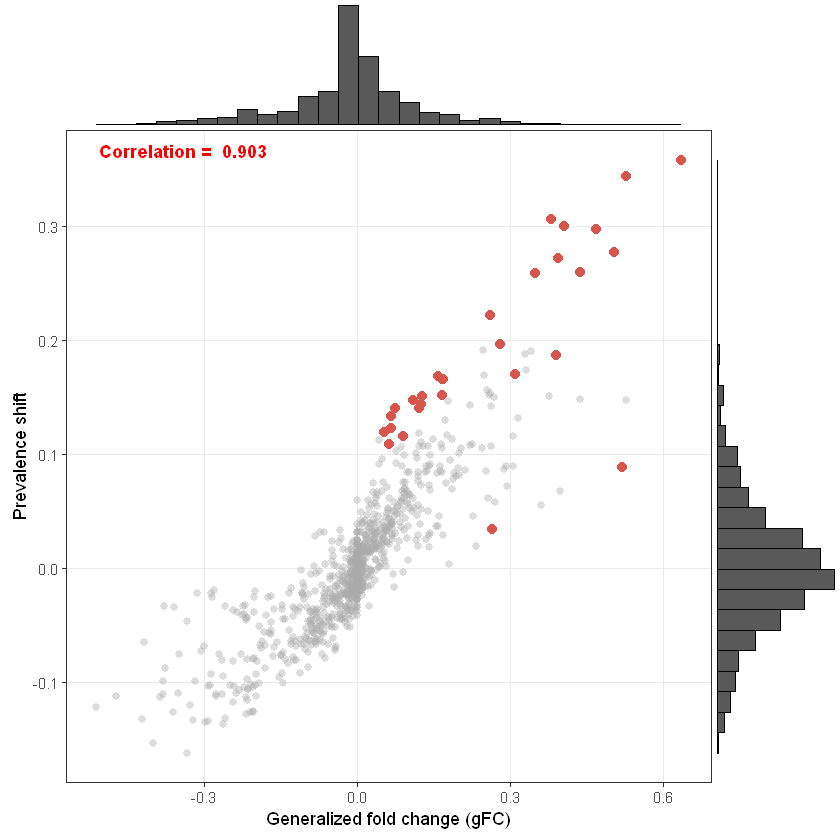

In [52]:
print(g.marg)
plot.new()
print(g.marg.2)
plot.new()
print(g.marg.3)
plot.new()
print(g.marg.4)
plot.new()
print(g.marg.5)

- The 1st figure is that the median fold change is plotted against the generalized fold change for all species. The core set of microbial CRC marker species is highlighted in red. 
- Scatter plots showing the relationship between fold change, generalized fold change (gFC) and AUROC or shift in prevalence between cancer (CRC) and healthy (CTR), with Spearman's rank correlations added in the top left corners. 
- gFC provides higher resolution (wider distribution around 0) and better correlation with the non-parametric AUROC effect size measure as well as prevalence shift, which captures the difference in prevalence of a species in CRC metagenomes relative to CTR metagenomes.